In [33]:
# Import necessary libraries
import os

import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.models as models

from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

In [2]:
# Define the constants
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() // 2

In [3]:
def set_seeds(seed: int=42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Only for Colab
# !unzip "/content/drive/MyDrive/Capstone Project/Dataset.zip"

In [6]:
# Get the pretrained ViT model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Dataset Preparations

In [7]:
# Declare the directories for training and testing datasets
train_dir = "Dataset/Training"
test_dir = "Dataset/Testing"

In [8]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = vit_weights.transforms()
print(vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [9]:
def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  class_names = train_data.classes

  # Split the training data into training and validation sets -> 80:20
  train_size = int(len(train_data) * 0.8)  
  val_size = len(train_data) - train_size
  train_data, val_data = random_split(train_data, [train_size, val_size])

  # Test Data
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size = batch_size,
      shuffle = True,
      num_workers = num_workers,
      pin_memory  = True,
  )

  val_dataloader = DataLoader(
    val_data,
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers,
    pin_memory = True,
  )

  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, val_dataloader, test_dataloader, class_names

In [10]:
train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = vit_transforms,
    batch_size = BATCH_SIZE # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)
) 

# Model Building

In [80]:
def train_model(model, epochs = 10):

    # Initialize lists to store training and validation metrics
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []

    train_acc_results = []
    train_loss_results = []
    val_acc_results = []
    val_loss_results = []    

    # Define the loss function and optimizer
    optimizer = torch.optim.Adam(
        params = model.parameters(),
        lr = 1e-3
    )
    loss_fn = torch.nn.CrossEntropyLoss()

    for e in range(epochs):
        print(f"\n Epoch {e+1}/{epochs}: ===>")
        # Set the model to training mode
        model.train()
        for img, lbl in train_dataloader:
            # Move the images and labels to the device
            img, lbl = img.to(device), lbl.to(device)
            # Reset gradients
            optimizer.zero_grad()
            # Forward pass
            output = model(img)
            # Calculate the loss
            loss = loss_fn(output, lbl)
            # Append the loss to the training loss list
            train_loss.append(loss.item())
            # Backward pass
            loss.backward()
            # Update the weights
            optimizer.step()
            # Calculate the accuracy
            y_pred_train = torch.argmax(torch.softmax(output, dim=1), dim=1)
            train_acc.append((y_pred_train == lbl).sum().item() / len(lbl))
        
        train_acc_res = sum(train_acc) / len(train_acc)
        train_acc_results.append(train_acc_res)
        train_loss_res = sum(train_loss) / len(train_loss)
        train_loss_results.append(train_loss_res)
        print(f"Training Loss: {train_loss_res:.4f}, Training Accuracy: {train_acc_res:.4f}")

        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for img, lbl in val_dataloader:
                # Move the images and labels to the device
                img, lbl = img.to(device), lbl.to(device)
                # Forward pass
                output = model(img)
                # Calculate the loss
                loss = loss_fn(output, lbl)
                val_loss.append(loss.item())
                # Calculate the accuracy
                y_pred_val = torch.argmax(torch.softmax(output, dim=1), dim=1)
                val_acc.append((y_pred_val == lbl).sum().item() / len(lbl))
            
        val_acc_res = sum(val_acc) / len(val_acc)
        val_acc_results.append(val_acc_res)
        val_loss_res = sum(val_loss) / len(val_loss)
        val_loss_results.append(val_loss_res)
        print(f"Validation Loss: {val_loss_res:.4f}, Validation Accuracy: {val_acc_res:.4f}")
    return train_acc_results, train_loss_results, val_acc_results, val_loss_results

# a. Vision Transformer Model

In [11]:
# Setup a ViT model instance with pretrained weights
vit = torchvision.models.vit_b_16(weights = vit_weights)

In [12]:
# Freeze the base parameters
for parameter in vit.parameters():
    parameter.requires_grad = False

In [13]:
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [14]:
# Define the class names
# class_names = ['Glioma', 'Meningioma', 'No Tumour', 'Pituitary']

In [15]:
# Set the random seed for reproducibility
set_seeds()

# Build the classifier head
vit.heads = nn.Sequential(
    nn.Linear(768, 400),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(400, 100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100, len(class_names))
)

In [16]:
# ! pip install torchinfo

In [17]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)

summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 4]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [18]:
# Set the model to the device
vit.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [23]:
results = train_model(vit, 15)


 Epoch 1/15: ===>
Training Loss: 0.4115, Training Accuracy: 0.8466
Validation Loss: 0.2556, Validation Accuracy: 0.9000

 Epoch 2/15: ===>
Training Loss: 0.3064, Training Accuracy: 0.8859
Validation Loss: 0.2215, Validation Accuracy: 0.9133

 Epoch 3/15: ===>
Training Loss: 0.2561, Training Accuracy: 0.9051
Validation Loss: 0.2077, Validation Accuracy: 0.9200

 Epoch 4/15: ===>
Training Loss: 0.2220, Training Accuracy: 0.9178
Validation Loss: 0.1980, Validation Accuracy: 0.9232

 Epoch 5/15: ===>
Training Loss: 0.1941, Training Accuracy: 0.9282
Validation Loss: 0.1873, Validation Accuracy: 0.9291

 Epoch 6/15: ===>
Training Loss: 0.1745, Training Accuracy: 0.9356
Validation Loss: 0.1850, Validation Accuracy: 0.9312

 Epoch 7/15: ===>
Training Loss: 0.1580, Training Accuracy: 0.9419
Validation Loss: 0.1845, Validation Accuracy: 0.9327

 Epoch 8/15: ===>
Training Loss: 0.1446, Training Accuracy: 0.9467
Validation Loss: 0.1812, Validation Accuracy: 0.9345

 Epoch 9/15: ===>
Training Loss

# b. VGG 16 Base Model

In [65]:
# Load the pretrained VGG16 model
vgg = models.vgg16(pretrained = True)

c:\Users\sidsu\miniconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sidsu\miniconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [66]:
# Freeze the base parameters
for param in vgg.parameters():
    param.requires_grad = False

In [67]:
# Build the classifier head for VGG16
vgg.classifier[6] = nn.Sequential(
    nn.Linear(vgg.classifier[6].in_features, 400),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(400, 100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100, len(class_names))
)

In [68]:
# Set the VGG16 model to the device
vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [69]:
results_vgg = train_model(vgg, 15)


 Epoch 1/15: ===>
Training Loss: 0.5669, Training Accuracy: 0.7793
Validation Loss: 0.3608, Validation Accuracy: 0.8618

 Epoch 2/15: ===>
Training Loss: 0.4840, Training Accuracy: 0.8134
Validation Loss: 0.3494, Validation Accuracy: 0.8688

 Epoch 3/15: ===>
Training Loss: 0.4480, Training Accuracy: 0.8281
Validation Loss: 0.3302, Validation Accuracy: 0.8809

 Epoch 4/15: ===>
Training Loss: 0.4217, Training Accuracy: 0.8405
Validation Loss: 0.3274, Validation Accuracy: 0.8818

 Epoch 5/15: ===>
Training Loss: 0.4034, Training Accuracy: 0.8486
Validation Loss: 0.3177, Validation Accuracy: 0.8849

 Epoch 6/15: ===>
Training Loss: 0.3863, Training Accuracy: 0.8554
Validation Loss: 0.3099, Validation Accuracy: 0.8873

 Epoch 7/15: ===>
Training Loss: 0.3691, Training Accuracy: 0.8614
Validation Loss: 0.3031, Validation Accuracy: 0.8897

 Epoch 8/15: ===>
Training Loss: 0.3568, Training Accuracy: 0.8657
Validation Loss: 0.3012, Validation Accuracy: 0.8921

 Epoch 9/15: ===>
Training Loss

## c. ResNet 50 

In [70]:
# Load the pretrained ResNet50 model
rnet = models.resnet50(pretrained=True)

c:\Users\sidsu\miniconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [71]:
# Freeze the base parameters
for param in rnet.parameters():
    param.requires_grad = False

In [72]:
# Build the classifier head for ResNet50
rnet.fc = nn.Sequential(
    nn.Linear(rnet.fc.in_features, 400),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(400, 100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100, len(class_names))
)

In [73]:
# Set the ResNet50 model to the device
rnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [74]:
results_rnet = train_model(rnet, 15)


 Epoch 1/15: ===>
Training Loss: 0.6279, Training Accuracy: 0.7521
Validation Loss: 0.3669, Validation Accuracy: 0.8728

 Epoch 2/15: ===>
Training Loss: 0.5122, Training Accuracy: 0.8034
Validation Loss: 0.3586, Validation Accuracy: 0.8741

 Epoch 3/15: ===>
Training Loss: 0.4593, Training Accuracy: 0.8269
Validation Loss: 0.3553, Validation Accuracy: 0.8693

 Epoch 4/15: ===>
Training Loss: 0.4205, Training Accuracy: 0.8417
Validation Loss: 0.3656, Validation Accuracy: 0.8670

 Epoch 5/15: ===>
Training Loss: 0.3994, Training Accuracy: 0.8503
Validation Loss: 0.3453, Validation Accuracy: 0.8742

 Epoch 6/15: ===>
Training Loss: 0.3794, Training Accuracy: 0.8582
Validation Loss: 0.3294, Validation Accuracy: 0.8795

 Epoch 7/15: ===>
Training Loss: 0.3662, Training Accuracy: 0.8632
Validation Loss: 0.3187, Validation Accuracy: 0.8834

 Epoch 8/15: ===>
Training Loss: 0.3510, Training Accuracy: 0.8693
Validation Loss: 0.3107, Validation Accuracy: 0.8854

 Epoch 9/15: ===>
Training Loss

# Model Testing

In [ ]:
def test_model(model):
    correct_acc_test = 0
    total_acc = 0
    test_acc = []

    with torch.no_grad():
        for img, lbl in test_dataloader:
            # Move the images and labels to the device
            img, lbl = img.to(device), lbl.to(device)
            # Forward pass
            output = model(img)
            # Calculate the accuracy
            y_pred_test = torch.argmax(torch.softmax(output, dim=1), dim=1)
            correct_acc_test += (y_pred_test == lbl).sum().item()
            total_acc += len(lbl)
    
    print(f"Test Accuracy: {correct_acc_test / total_acc:.4f}")

## a. Vision Transformer

In [25]:
test_model(vit)

Test Accuracy: 0.9619


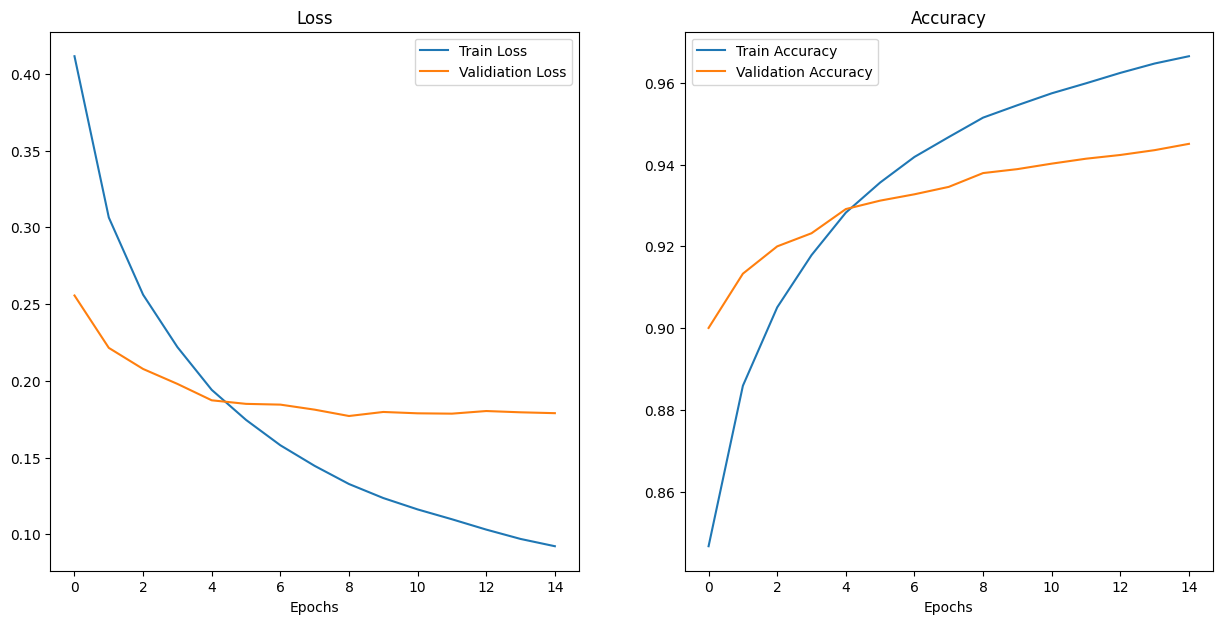

In [32]:
plot_loss_curves(results)

## b. VGG - 16

In [76]:
test_model(vgg)

Test Accuracy: 0.9169


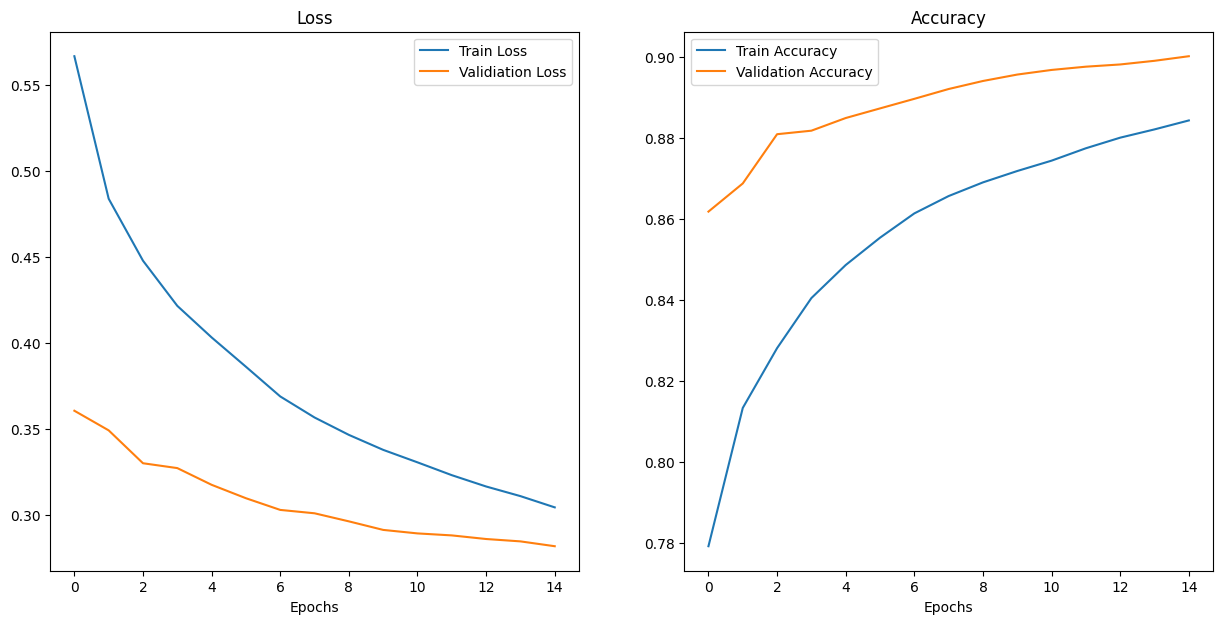

In [77]:
plot_loss_curves(results_vgg)

## c. ResNet - 50

In [78]:
test_model(rnet)

Test Accuracy: 0.9054


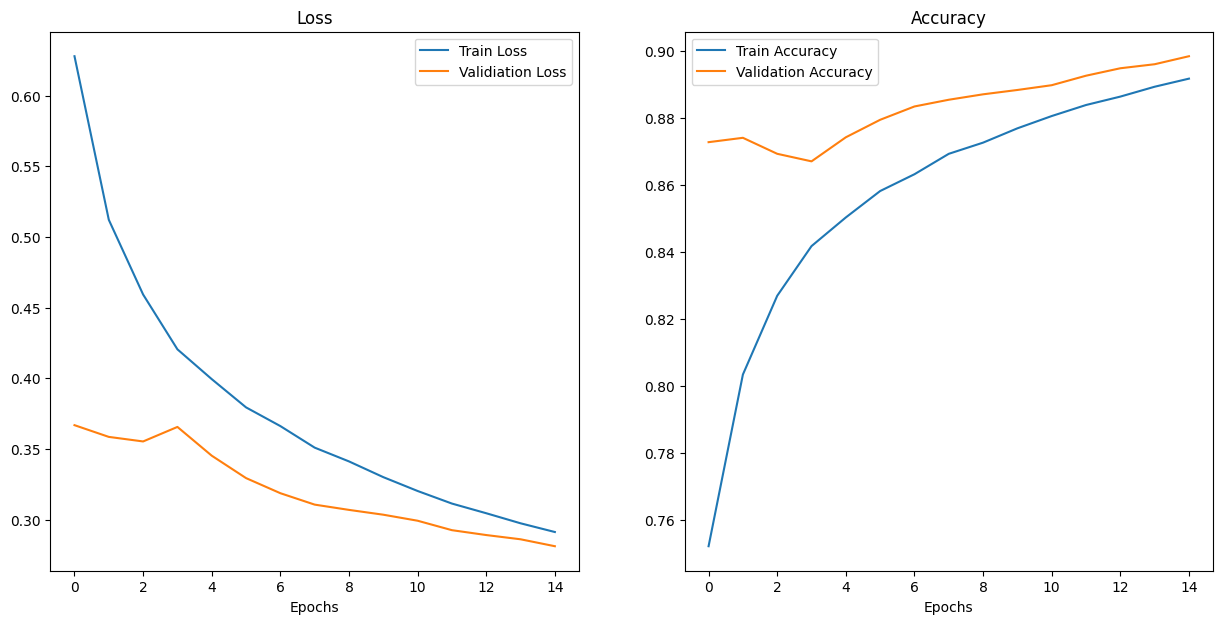

In [79]:
plot_loss_curves(results_rnet)

# Performance Comparison Plot

In [82]:
import numpy as np

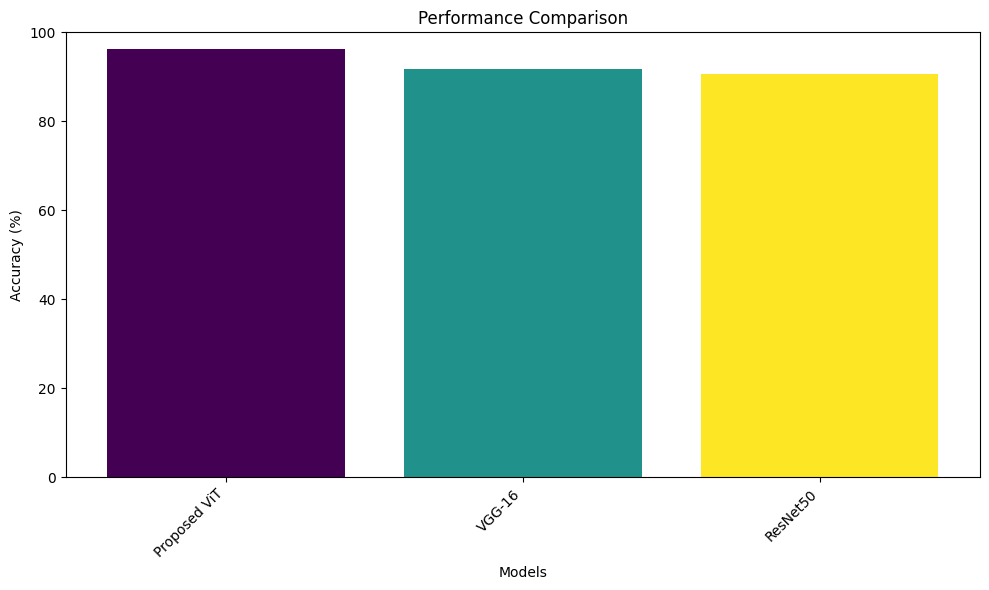

In [ ]:
# Performance Comparison Plot
values = [96.19, 91.69, 90.54]
labels = ['Proposed ViT', 'VGG-16', 'ResNet50']

# Use the viridis colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(values)))

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)

# Add title and labels
plt.title('Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()